### Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

import os
from enum import Enum
from typing import Tuple, Callable
from kagglehub import dataset_download

c:\Users\João Carvalho\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregamento e Pré-Processamento do Dataset

In [2]:
__ONLINE_DATASET_URI = "birdy654/cifake-real-and-ai-generated-synthetic-images"
__BASE_LOCAL_DATA_PATHS = [
    ("../data/train/REAL", 50000),
    ("../data/train/FAKE", 50000),
    ("../data/test/REAL", 10000),
    ("../data/test/FAKE", 10000)
]

class ModelType(Enum):
    GENERAL = "general"
    EFFICIENTNET_B0 = "efficientnet_b0"
    RESNET50 = "resnet50"
    XCEPTION = "xception"
    MOBILENET_V2 = "mobilenet_v2"
    SHUFFLENET_V2 = "shufflenet_v2"

def _get_tf_preprocess_fn(model_type: ModelType,
                          resize_to: Tuple[int, int]) -> Callable[[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    def preprocess(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        image = tf.image.resize(image, resize_to)
        image = tf.cast(image, tf.float32) / 255.0

        if model_type in [ModelType.EFFICIENTNET_B0, ModelType.RESNET50]:
            mean = tf.constant([0.485, 0.456, 0.406])
            std = tf.constant([0.229, 0.224, 0.225])
            image = (image - mean) / std
        elif model_type in [ModelType.MOBILENET_V2]:
            image = (image - 0.5) * 2.0
        return image, label
    return preprocess

def load_and_preprocess_data_tf(resize_to: Tuple[int, int] = (224, 224),
                                batch_size: int = 32,
                                model_type: ModelType = ModelType.GENERAL,
                                manual_path: str = None) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    if manual_path is not None:
        train_path = os.path.join(manual_path, "train")
        test_path = os.path.join(manual_path, "test")
    else:
        train_path = "../data/train"
        test_path = "../data/test"


    preprocess_fn = _get_tf_preprocess_fn(model_type, resize_to)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=True
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_path,
        image_size=resize_to,
        batch_size=batch_size,
        shuffle=False
    ).map(preprocess_fn).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds


In [17]:
train_path = "/content/cifake/train"
test_path = "/content/cifake/test"


In [ ]:
batch_size = 32
image_size = (224, 224)
pi = "C:/TT"
train_ds, test_ds = load_and_preprocess_data_tf(
    resize_to=image_size,
    batch_size=batch_size,
    model_type=ModelType.MOBILENET_V2,
    manual_path = r"C:/TT/cifake" #local do dataset no meu pc

)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


### Divisão Holdout

In [12]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
total_samples = total_batches * batch_size

In [13]:
# Define proporção de treino (70%) e validação (30%) usando o número de batches
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

In [14]:
# Embaralha os batches do dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

In [15]:
# Divisão trenio e validação
train_ds = train_ds_shuffled.take(train_batches)
val_ds = train_ds_shuffled.skip(train_batches)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [16]:
print(f"Batches de treino: {train_batches}")
print(f"Batches de validação: {val_batches}")
print(f"Aproximadamente {train_batches * batch_size} amostras de treino")
print(f"Aproximadamente {val_batches * batch_size} amostras de validação")

Batches de treino: 2187
Batches de validação: 938
Aproximadamente 69984 amostras de treino
Aproximadamente 30016 amostras de validação


## Treino

### Modelo

**MobileNet V2**

O MobileNet V2 é uma arquitetura de rede neural convolucional eficiente e leve, desenvolvida pelo Google em 2018, especialmente voltada para aplicações em dispositivos móveis e embarcados. Ele é uma evolução do MobileNet original, trazendo melhorias significativas em desempenho e economia computacional, sem comprometer a precisão.

Sua arquitetura é composta por três principais elementos: as convoluções separáveis em profundidade, os blocos de resíduos invertidos e os gargalos lineares. As convoluções separáveis reduzem drasticamente o número de parâmetros e operações necessárias. Os blocos de resíduos invertidos conectam camadas com profundidades diferentes para facilitar o fluxo de informações, enquanto os gargalos lineares evitam perda de dados importantes durante o processamento.

O MobileNet V2 foi treinado em bases de dados como o ImageNet, atingindo bons resultados em tarefas como classificação de imagens, detecção de objetos e segmentação semântica. Seu grande diferencial está no equilíbrio entre precisão e eficiência, sendo ideal para aplicações em tempo real, como reconhecimento facial, realidade aumentada e sistemas inteligentes em dispositivos com recursos limitados.

Fonte: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

In [17]:
device = "GPU" if len(tf.config.list_physical_devices("GPU")) > 0 else "CPU"
print(f"Usando: {device}")

Usando: CPU


In [18]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tf.debugging.set_log_device_placement(True)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1349s 547ms/step - accuracy: 0.8036 - loss: 0.4231 - val_accuracy: 0.8811 - val_loss: 0.2882
Epoch 2/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1179s 532ms/step - accuracy: 0.8662 - loss: 0.3157 - val_accuracy: 0.8933 - val_loss: 0.2609
Epoch 3/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1173s 531ms/step - accuracy: 0.8770 - loss: 0.2961 - val_accuracy: 0.8984 - val_loss: 0.2477
Epoch 4/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1188s 535ms/step - accuracy: 0.8827 - loss: 0.2814 - val_accuracy: 0.9024 - val_loss: 0.2410
Epoch 5/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1193s 539ms/step - accuracy: 0.8875 - loss: 0.2738 - val_accuracy: 0.9073 - val_loss: 0.2316
Epoch 6/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1191s 537ms/step - accuracy: 0.8912 - loss: 0.2640 - val_accuracy: 0.9088 - val_loss: 0.2280
Epoch 7/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1182s 533ms/step - accuracy: 0.8930 - loss: 0.2610 - val_accuracy: 0.9082 - val_loss: 0.2238
Epoch 8/50
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 1195s 540ms/s

625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 429ms/step


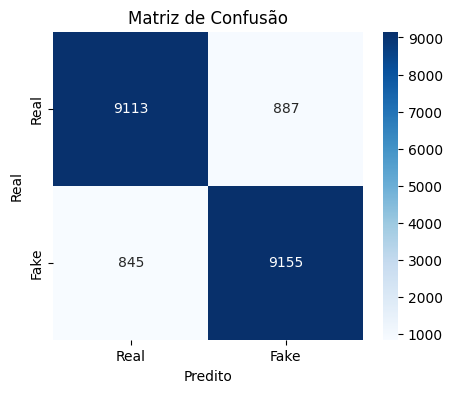


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.92      0.91      0.91     10000
        Fake       0.91      0.92      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

AUC (ROC): 0.9723


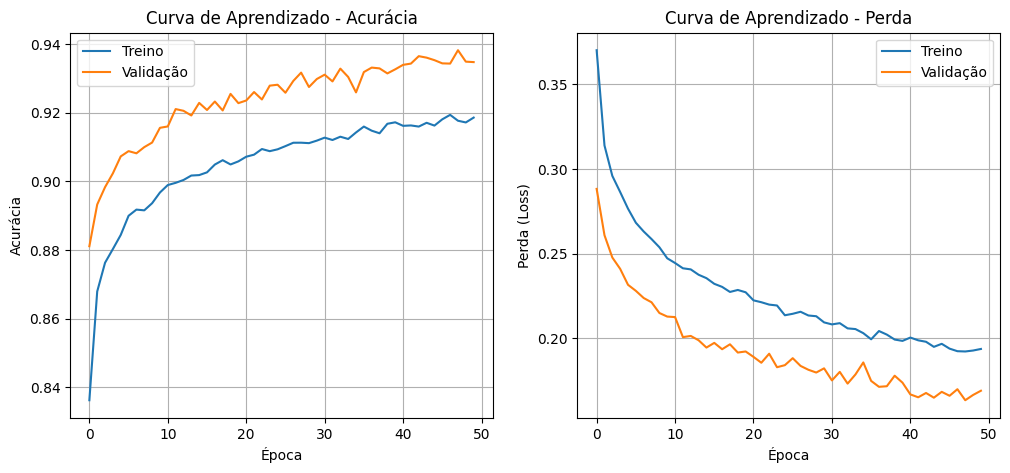

In [22]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Extrair labels verdadeiros do dataset de teste
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Flatten y_pred_prob para garantir formato correto
y_pred_prob = y_pred_prob.ravel()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (ROC): {roc_auc:.4f}")

plt.figure(figsize=(12, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Aprendizado - Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Aprendizado - Perda")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid()

plt.show()

In [20]:
import json
with open('history_effct.json', 'w') as f:
    json.dump(history.history, f)

In [15]:
model.save("MobileNet.keras")